## hanlp的词典模式

之前我们看了hanlp的词性标注，现在我们就要使用自定义词典与停用词功能了，首先关于HanLP的词性标注方式具体请看[HanLP词性标注集](http://www.hankcs.com/nlp/part-of-speech-tagging.html#h2-8)。

其核心词典形式如下：
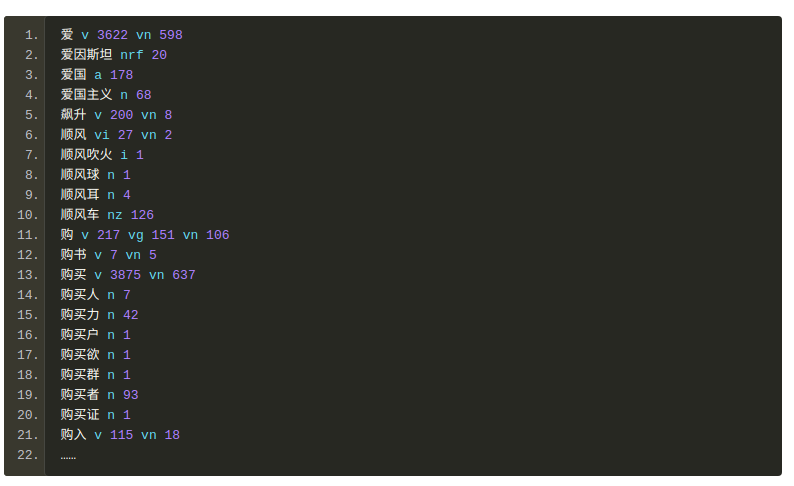


## 自定义词典

自定义词典有多种添加模式，首先是展示的一个小例子，展示了词汇的动态增加与强行插入，删除等。更复杂的内容请参考后边的第二段代码。

### 简单的例子

In [10]:
from pyhanlp import *

text = "攻城狮逆袭单身狗，迎娶白富美，走上人生巅峰"  # 怎么可能噗哈哈！

print(HanLP.segment(text))

CustomDictionary = JClass("com.hankcs.hanlp.dictionary.CustomDictionary")
CustomDictionary.add("攻城狮")  # 动态增加
CustomDictionary.insert("白富美", "nz 1024")  # 强行插入
#CustomDictionary.remove("攻城狮"); # 删除词语（注释掉试试）
CustomDictionary.add("单身狗", "nz 1024 n 1")


# 展示该单词词典中的词频统计 展示分词
print(CustomDictionary.get("单身狗"))
print(HanLP.segment(text))


# 增加用户词典,对其他分词器同样有效
# 注意此处,CRF分词器将单身狗分为了n 即使单身狗:"nz 1024 n 1"
CRFnewSegment = HanLP.newSegment("crf")
print(CRFnewSegment.seg(text))

[攻城狮, 逆袭, 单身狗, ，, 迎娶, 白富美, ，, 走上, 人生, 巅峰]
nz 1024 n 1 
[攻城狮, 逆袭, 单身狗, ，, 迎娶, 白富美, ，, 走上, 人生, 巅峰]
[攻城, 狮逆袭, 单身狗, ，, 迎娶, 白富美, ，, 走, 上, 人生, 巅峰]


### 复杂的例子

In [5]:
""" 演示自定义词性,以及往词典中插入自定义词性的词语
    !!!由于采用了反射技术,用户需对本地环境的兼容性和稳定性负责!!!

TO-DO
如果使用了动态词性之后任何类使用了switch(nature)语句,必须注册每个类
"""
# 对于系统中已有的词性,可以直接获取
Nature = JClass("com.hankcs.hanlp.corpus.tag.Nature")
pc_nature = Nature.fromString("n")
print(pc_nature)
# 此时系统中没有"电脑品牌"这个词性
pc_nature = Nature.fromString("电脑品牌")
print(pc_nature)
# 我们可以动态添加一个
pc_nature = Nature.create("电脑品牌");
print(pc_nature)
# 可以将它赋予到某个词语
LexiconUtility = JClass("com.hankcs.hanlp.utility.LexiconUtility")
LexiconUtility.setAttribute("苹果电脑", pc_nature)
# 或者
LexiconUtility.setAttribute("苹果电脑", "电脑品牌 1000")
# 它们将在分词结果中生效
term_list = HanLP.segment("苹果电脑可以运行开源阿尔法狗代码吗")
print(term_list)
for term in term_list:
    if term.nature == pc_nature:
        print("找到了 [{}] : {}\n".format(pc_nature, term.word))

# 还可以直接插入到用户词典
CustomDictionary = JClass("com.hankcs.hanlp.dictionary.CustomDictionary")
CustomDictionary.insert("阿尔法狗", "科技名词 1024")
StandardTokenizer = JClass("com.hankcs.hanlp.tokenizer.StandardTokenizer")
StandardTokenizer.SEGMENT.enablePartOfSpeechTagging(True)  # 依然支持隐马词性标注
term_list = HanLP.segment("苹果电脑可以运行开源阿尔法狗代码吗")
print(term_list)

n
None
电脑品牌
[苹果电脑/电脑品牌, 可以/v, 运行/vn, 开源/v, 阿尔法/nrf, 狗/n, 代码/n, 吗/y]
找到了 [电脑品牌] : 苹果电脑

[苹果电脑/电脑品牌, 可以/v, 运行/vn, 开源/v, 阿尔法狗/科技名词, 代码/n, 吗/y]



## 关于自定义词典的说明（原作者的原文）
- 说明
  * `CustomDictionary`是一份全局的用户自定义词典，可以随时增删，影响全部分词器。另外可以在任何分词器中关闭它。通过代码动态增删不会保存到词典文件。
  * 中文分词≠词典，词典无法解决中文分词，`Segment`提供高低优先级应对不同场景，请参考[FAQ](https://github.com/hankcs/HanLP/wiki/FAQ#%E4%B8%BA%E4%BB%80%E4%B9%88%E4%BF%AE%E6%94%B9%E4%BA%86%E8%AF%8D%E5%85%B8%E8%BF%98%E6%98%AF%E6%B2%A1%E6%9C%89%E6%95%88%E6%9E%9C)。
- 追加词典
  * `CustomDictionary`主词典文本路径是`data/dictionary/custom/CustomDictionary.txt`，用户可以在此增加自己的词语（不推荐）；也可以单独新建一个文本文件，通过配置文件`CustomDictionaryPath=data/dictionary/custom/CustomDictionary.txt; 我的词典.txt;`来追加词典（推荐）。
  * 始终建议将相同词性的词语放到同一个词典文件里，便于维护和分享。
- 词典格式
  * 每一行代表一个单词，格式遵从`[单词] [词性A] [A的频次] [词性B] [B的频次] ...` 如果不填词性则表示采用词典的默认词性。
  * 词典的默认词性默认是名词n，可以通过配置文件修改：`全国地名大全.txt ns;`如果词典路径后面空格紧接着词性，则该词典默认是该词性。
  * 在统计分词中，并不保证自定义词典中的词一定被切分出来。用户可在理解后果的情况下通过`Segment#enableCustomDictionaryForcing`强制生效。
  * 关于用户词典的更多信息请参考**词典说明**一章（请看本文最后）。
  
## 停用词

关于停用词，我同样先给出了一个简单的例子，你可以使用这个例子来完成你所需要的功能。要注意的一点是，因为java中的类所返回的数据类型与Python不统一，所以当你使用不同的函数的时候，一定要先检查输出结果在Python中的类型，不然可能会出现意想不到的问题。

假如你想了解更多，可以看第二个更复杂的例子。

### 简单的例子

In [11]:
# 使用停用词的简单例子

text = "小区居民有的反对喂养流浪猫"
CRFnewSegment = HanLP.newSegment("crf")
term_list = CRFnewSegment.seg(text)
# BasicTokenizer = SafeJClass("com.hankcs.hanlp.tokenizer.BasicTokenizer")
# term_list = BasicTokenizer.segment(text)

CoreStopWordDictionary = JClass("com.hankcs.hanlp.dictionary.stopword.CoreStopWordDictionary")
CoreStopWordDictionary.apply(term_list)
HanLP.Config.ShowTermNature = False

print(term_list)
print([i.word for i in term_list])

[小区, 居民, 反对, 养, 流, 浪, 猫]
['小区', '居民', '反对', '养', '流', '浪', '猫']


### 复杂的例子

In [6]:
# 停用词

# 在import pyhanlp之前编译自己的Java class，并放入pyhanlp/static中
import os

from pyhanlp.static import STATIC_ROOT, HANLP_JAR_PATH

java_code_path = os.path.join(STATIC_ROOT, 'MyFilter.java')
with open(java_code_path, 'w') as out:
    java_code = """
import com.hankcs.hanlp.dictionary.stopword.CoreStopWordDictionary;
import com.hankcs.hanlp.dictionary.stopword.Filter;
import com.hankcs.hanlp.seg.common.Term;

public class MyFilter implements Filter
{
    public boolean shouldInclude(Term term)
    {
        if (term.nature.startsWith('m')) return true; // 数词保留
        return !CoreStopWordDictionary.contains(term.word); // 停用词过滤
    }
}
"""
    out.write(java_code)
os.system('javac -cp {} {} -d {}'.format(HANLP_JAR_PATH, java_code_path, STATIC_ROOT))
# 编译结束才可以启动hanlp

CoreStopWordDictionary = JClass("com.hankcs.hanlp.dictionary.stopword.CoreStopWordDictionary")
Filter = JClass("com.hankcs.hanlp.dictionary.stopword.Filter")
Term = JClass("com.hankcs.hanlp.seg.common.Term")
BasicTokenizer = JClass("com.hankcs.hanlp.tokenizer.BasicTokenizer")
NotionalTokenizer = JClass("com.hankcs.hanlp.tokenizer.NotionalTokenizer")

text = "小区居民有的反对喂养流浪猫，而有的居民却赞成喂养这些小宝贝"
# 可以动态修改停用词词典
CoreStopWordDictionary.add("居民")
print(NotionalTokenizer.segment(text))
CoreStopWordDictionary.remove("居民")
print(NotionalTokenizer.segment(text))

# 可以对任意分词器的结果执行过滤
term_list = BasicTokenizer.segment(text)
print(term_list)
CoreStopWordDictionary.apply(term_list)
print(term_list)

# 还可以自定义过滤逻辑
MyFilter = JClass('MyFilter')
CoreStopWordDictionary.FILTER = MyFilter()
print(NotionalTokenizer.segment("数字123的保留"))  # “的”位于stopwords.txt所以被过滤，数字得到保留

[小区/n, 反对/v, 喂养/v, 流浪猫/nz, 赞成/v, 喂养/v, 小宝贝/nz]
[小区/n, 居民/n, 反对/v, 喂养/v, 流浪猫/nz, 居民/n, 赞成/v, 喂养/v, 小宝贝/nz]
[小区/n, 居民/n, 有/vyou, 的/ude1, 反对/v, 喂养/v, 流浪猫/nz, ，/w, 而/cc, 有的/rz, 居民/n, 却/d, 赞成/v, 喂养/v, 这些/rz, 小宝贝/nz]
[小区/n, 居民/n, 反对/v, 喂养/v, 流浪猫/nz, 居民/n, 赞成/v, 喂养/v, 小宝贝/nz]
[数字/n, 123/m, 保留/v]


## 词典说明（原作者原文）
本章详细介绍HanLP中的词典格式，满足用户自定义的需要。HanLP中有许多词典，它们的格式都是相似的，形式都是文本文档，随时可以修改。
### 基本格式
词典分为词频词性词典和词频词典。

- 词频词性词典（如`CoreNatureDictionary.txt`）
   * 每一行代表一个单词，格式遵从`[单词] [词性A] [A的频次] [词性B] [B的频次] ...`。
   * 支持省略词性和频次，直接一行一个单词。
   * `.txt`词典文件的分隔符为空格或制表符，所以不支持含有空格的词语。如果需要支持空格，请使用英文逗号`,`分割的**纯文本**`.csv`文件。在使用Excel等富文本编辑器时，则请注意保存为**纯文本**形式。
- 词频词典（如`CoreNatureDictionary.ngram.txt`）
  * 每一行代表一个单词或条目，格式遵从`[单词] [单词的频次]`。
  * 每一行的分隔符为空格或制表符。

少数词典有自己的专用格式，比如同义词词典兼容《同义词词林扩展版》的文本格式，而转移矩阵词典则是一个csv表格。

下文主要介绍通用词典，如不注明，词典特指通用词典。

### 数据结构

Trie树（字典树）是HanLP中使用最多的数据结构，为此，我实现了通用的Trie树，支持泛型、遍历、储存、载入。

用户自定义词典采用AhoCorasickDoubleArrayTrie和二分Trie树储存，其他词典采用基于[双数组Trie树(DoubleArrayTrie)](http://www.hankcs.com/program/java/%E5%8F%8C%E6%95%B0%E7%BB%84trie%E6%A0%91doublearraytriejava%E5%AE%9E%E7%8E%B0.html)实现的[AC自动机AhoCorasickDoubleArrayTrie](http://www.hankcs.com/program/algorithm/aho-corasick-double-array-trie.html)。关于一些常用数据结构的性能评估，请参考[wiki](https://github.com/hankcs/HanLP/wiki/%E6%95%B0%E6%8D%AE%E7%BB%93%E6%9E%84)。

### 储存形式

词典有两个形态：文本文件(filename.txt)和缓存文件(filename.txt.bin或filename.txt.trie.dat和filename.txt.trie.value)。

- 文本文件 
  * 采用明文储存，UTF-8编码，CRLF换行符。
- 缓存文件
  * 就是一些二进制文件，通常在文本文件的文件名后面加上.bin表示。有时候是.trie.dat和.trie.value。后者是历史遗留产物，分别代表trie树的数组和值。
  * 如果你修改了任何词典，只有删除缓存才能生效。

### 修改方法

HanLP的核心词典训练自人民日报2014语料，语料不是完美的，总会存在一些错误。这些错误可能会导致分词出现奇怪的结果，这时请打开调试模式排查问题：**（本文作者FontTian注：在本文动笔前，原词典一进变为了9970万版本的最大中文语料。但是词典说明中原作者没改）**
```java
HanLP.Config.enableDebug();
```
- 核心词性词频词典
  * 比如你在`data/dictionary/CoreNatureDictionary.txt`中发现了一个不是词的词，或者词性标注得明显不对，那么你可以修改它，然后删除缓存文件使其生效。
  * 目前`CoreNatureDictionary.ngram.txt`的缓存依赖于`CoreNatureDictionary.txt`的缓存，修改了后者之后必须同步删除前者的缓存，否则可能出错
- 核心二元文法词典
  * 二元文法词典`data/dictionary/CoreNatureDictionary.ngram.txt`储存的是两个词的接续，如果你发现不可能存在这种接续时，删掉即可。
  * 你也可以添加你认为合理的接续，但是这两个词必须同时在核心词典中才会生效。
- 命名实体识别词典
  * 基于角色标注的命名实体识别比较依赖词典，所以词典的质量大幅影响识别质量。
  * 这些词典的格式与原理都是类似的，请阅读[相应的文章](http://www.hankcs.com/category/nlp/ner/)或代码修改它。